In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Function to calculate R2 score
def calculate_r2(actual, predicted):
    return pearsonr(actual.flatten(), predicted.flatten())[0]**2

# Count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Data augmentation transformations
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(5, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomResizedCrop(size=(135, 180), scale=(0.95, 1.3), antialias=True),
])

# Create a custom dataset class (assuming you have a custom dataset)
class RHEEDVideoDataset(Dataset):
    def __init__(self, videos, targets, transform=None,augment=True):
        self.videos = videos
        self.targets = targets
        self.transform = transform
        self.augment = augment
    
    def __len__(self):
        return len(self.videos)
    
    def __getitem__(self, idx):
        x = self.videos[idx]
        x = torch.log(x)
        x = (x-x.min())/(x.max()-x.min())
        y = self.targets[idx]
        
        if self.transform:
            x = self.transform(x)
            if self.augment:
                y = y + torch.randn_like(y) * 1.5
            else:
                y = y
        return x, y/100


# Load the data
loaded_data = np.load('rheed_stoich_data.npz')
stoich = loaded_data['stoich'].astype(np.float32)
images = loaded_data['images'].astype(np.float32)

stoich = torch.from_numpy(stoich).unsqueeze(1)
images = torch.from_numpy(images).unsqueeze(1)

downsample = 4
resize_xform = transforms.Resize((540//downsample,720//downsample),antialias=True)
images = torch.stack([resize_xform(img) for img in images])

# Split the data into training and testing sets
X_train_images, X_test_images, y_train, y_test = train_test_split(images, stoich, test_size=0.4, random_state=2)
train_dataset = RHEEDVideoDataset(X_train_images, y_train, transform=data_transforms, augment=True)
test_dataset = RHEEDVideoDataset(X_test_images, y_test, transform=data_transforms, augment=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Print the shapes of all the arrays (for verification)
print("X_train shape:", X_train_images.shape)
print("X_test shape:", X_test_images.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([18, 1, 135, 180])
X_test shape: torch.Size([13, 1, 135, 180])
y_train shape: torch.Size([18, 1])
y_test shape: torch.Size([13, 1])


In [2]:
class Conv2dGLU2(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(Conv2dGLU2, self).__init__()
        # Double the output channels to allow splitting for the gate
        self.conv = nn.Conv2d(
            in_channels,
            out_channels * 2,  # Double the output channels for GLU
            kernel_size,
            stride=stride,
            padding=padding
        )
        self.batchnorm = nn.BatchNorm2d(out_channels*2) 
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for the gate

    def forward(self, x):
        # Perform convolution
        conv_out = self.conv(x)
        conv_out = self.batchnorm(conv_out)
        # Split the output into two halves
        out, gate = torch.chunk(conv_out, 2, dim=1)
        # Apply gating
        return F.leaky_relu(out) * self.sigmoid(gate)
    
    
class GatedCNN2(nn.Module):
    def __init__(self, input_channels = 1,
                 start_channels = 64,
                 dropout_pct = 0.1,
                 kernel_size = 3,
                 pooling_function=nn.MaxPool2d(2),
                 final_pooling=nn.AdaptiveMaxPool2d((1, 1)),
                 num_outputs=1):
        super(GatedCNN2, self).__init__()
        
        
        self.conv1 = Conv2dGLU2(1, start_channels, kernel_size, 1)
        
        self.conv2 = Conv2dGLU2(start_channels, start_channels*4, kernel_size, 1)
        
        self.conv3 = Conv2dGLU2(start_channels*4, start_channels*8, kernel_size, 1)

        self.pool =  pooling_function
        
        self.final_pool = final_pooling
        self.flatten = nn.Flatten(start_dim=1)
        
        self.fc = nn.Sequential(
            nn.GLU(dim=-1), 
            nn.Dropout(dropout_pct),
            nn.GLU(dim=-1), 
            nn.Linear(start_channels*2, num_outputs)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.pool(x)
        
        x = self.flatten(self.final_pool(x))
        x = self.fc(x)
        return x
    
def model_train(config):
    # Create the model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    checkpoint_path = config['path']+'GatedCNN_{}_{}_{}_{}_{}.pth'.format(config['start_channels'],
                                     config['kernel_size'],
                                     config['dropout_pct'],
                                     config['pooling_function'],
                                     config['final_pooling'])
    
    model = GatedCNN2(
                 input_channels = 1,
                 start_channels = config['start_channels'],
                 kernel_size = config['kernel_size'],
                 dropout_pct = config['dropout_pct'],
                 pooling_function=config['pooling_function'],
                 final_pooling=config['final_pooling'],
                 num_outputs=1).to(device)

    print('Total trainable parameters = ', count_parameters(model))

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])

    # Define the loss function
    #criterion = nn.MSELoss()
    criterion = nn.L1Loss()

    # Number of epochs
    num_epochs = config['epochs']

    # Lists to store loss values
    train_losses = []
    val_losses = []

    train_preds_list = []
    val_preds_list = []

    best_val_loss = float('inf')
    best_model_weights = None
    best_val_R2 = 1.0e-6

    train_r2s = []
    val_r2s = []
    
    val_r2_ema = None
    val_r2_emas = []
    alpha = 0.1  # Smoothing factor, can be adjusted (0 < alpha <= 1)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        trainbatch_predictions = np.zeros(0)
        trainbatch_targets = np.zeros(0)
        for inputs, targets in train_loader:

            inputs = inputs.to(device)
            targets = targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, targets)
            trainbatch_predictions = np.append(trainbatch_predictions,outputs.flatten().cpu().detach().numpy())
            trainbatch_targets = np.append(trainbatch_targets,targets.flatten().cpu().detach().numpy())
            #train_preds_list.append([outputs,targets])
            #TR2 = calculate_r2(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()

        # Calculate average training loss
        train_loss = running_loss / len(train_loader)
        train_r2 = calculate_r2(trainbatch_targets, trainbatch_predictions)
        train_losses.append(train_loss)
        train_r2s.append(train_r2)

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            valbatch_predictions = np.zeros(0)
            valbatch_targets = np.zeros(0)

            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute the validation loss
                loss = criterion(outputs, targets)
                valbatch_predictions = np.append(valbatch_predictions,outputs.flatten().cpu().detach().numpy())
                valbatch_targets = np.append(valbatch_targets,targets.flatten().cpu().detach().numpy())

                # Accumulate validation loss
                val_loss += loss.item()

        # Average validation loss
        val_loss /= len(test_loader)
        val_r2 = calculate_r2(valbatch_targets, valbatch_predictions)
        val_losses.append(val_loss)
        val_r2s.append(val_r2)
        
        # Calculate exponential moving average
        if val_r2_ema is None:
            val_r2_ema = val_r2  # Initialize with the first val_r2
        else:
            val_r2_ema = alpha * val_r2 + (1 - alpha) * val_r2_ema
            val_r2_emas.append(val_r2_ema)
            
        if val_r2_ema > best_val_R2:
            best_val_R2 = val_r2_ema
            #if best_val_R2 >0.85:
            print('New Best..... Saving Model')
            torch.save(model.state_dict(),checkpoint_path)

        print(f"Epoch: {epoch},Train Loss: {train_loss:.3e}, "
      f"Val Loss: {val_loss:.3e}, "
      f"Train R2: {train_r2:.3f}, "
      f"Val R2: {val_r2:.3f}, "
      f"Val R2 EMA: {val_r2_ema:.3f}")
    return train_losses, val_losses, train_r2s, val_r2s, val_r2_emas,model


In [3]:
config = {
        'start_channels': 16,
        'kernel_size': 7,
        'dropout_pct': 0.15229380191306383,
        'pooling_function': nn.MaxPool2d(2),
        'final_pooling': nn.AdaptiveMaxPool2d((1, 1)),
        "lr": 0.0248,
        'epochs': 500,
        'path':'test'
}


train_losses, val_losses, train_r2s, val_r2s, val_r2_emas, model = model_train(config)

Total trainable parameters =  906017
New Best..... Saving Model
Epoch: 0,Train Loss: 1.659e+00, Val Loss: 2.092e+01, Train R2: 0.025, Val R2: 0.024, Val R2 EMA: 0.024
Epoch: 1,Train Loss: 4.935e+00, Val Loss: 1.562e+01, Train R2: 0.100, Val R2: 0.003, Val R2 EMA: 0.022
Epoch: 2,Train Loss: 2.417e+00, Val Loss: 8.200e+00, Train R2: 0.141, Val R2: 0.000, Val R2 EMA: 0.020
Epoch: 3,Train Loss: 1.419e+00, Val Loss: 3.650e+00, Train R2: 0.125, Val R2: 0.001, Val R2 EMA: 0.018
New Best..... Saving Model
Epoch: 4,Train Loss: 6.137e-01, Val Loss: 1.026e+00, Train R2: 0.046, Val R2: 0.131, Val R2 EMA: 0.029
New Best..... Saving Model
Epoch: 5,Train Loss: 2.526e-01, Val Loss: 1.711e-01, Train R2: 0.010, Val R2: 0.362, Val R2 EMA: 0.063
New Best..... Saving Model
Epoch: 6,Train Loss: 3.282e-01, Val Loss: 7.145e-01, Train R2: 0.006, Val R2: 0.666, Val R2 EMA: 0.123
New Best..... Saving Model
Epoch: 7,Train Loss: 4.385e-01, Val Loss: 7.810e-01, Train R2: 0.061, Val R2: 0.522, Val R2 EMA: 0.163
New 

Epoch: 76,Train Loss: 6.508e-02, Val Loss: 6.021e-02, Train R2: 0.287, Val R2: 0.298, Val R2 EMA: 0.216
Epoch: 77,Train Loss: 8.419e-02, Val Loss: 5.932e-02, Train R2: 0.071, Val R2: 0.466, Val R2 EMA: 0.241
Epoch: 78,Train Loss: 8.713e-02, Val Loss: 6.625e-02, Train R2: 0.145, Val R2: 0.338, Val R2 EMA: 0.251
Epoch: 79,Train Loss: 9.287e-02, Val Loss: 5.735e-02, Train R2: 0.225, Val R2: 0.278, Val R2 EMA: 0.253
Epoch: 80,Train Loss: 5.634e-02, Val Loss: 6.844e-02, Train R2: 0.473, Val R2: 0.212, Val R2 EMA: 0.249
Epoch: 81,Train Loss: 5.579e-02, Val Loss: 6.886e-02, Train R2: 0.426, Val R2: 0.231, Val R2 EMA: 0.247
Epoch: 82,Train Loss: 8.399e-02, Val Loss: 7.909e-02, Train R2: 0.079, Val R2: 0.168, Val R2 EMA: 0.240
Epoch: 83,Train Loss: 7.112e-02, Val Loss: 7.739e-02, Train R2: 0.223, Val R2: 0.195, Val R2 EMA: 0.235
Epoch: 84,Train Loss: 5.943e-02, Val Loss: 6.365e-02, Train R2: 0.433, Val R2: 0.267, Val R2 EMA: 0.238
Epoch: 85,Train Loss: 6.024e-02, Val Loss: 6.163e-02, Train R2: 

Epoch: 152,Train Loss: 5.739e-02, Val Loss: 5.353e-02, Train R2: 0.605, Val R2: 0.534, Val R2 EMA: 0.538
New Best..... Saving Model
Epoch: 153,Train Loss: 5.385e-02, Val Loss: 5.764e-02, Train R2: 0.480, Val R2: 0.671, Val R2 EMA: 0.551
New Best..... Saving Model
Epoch: 154,Train Loss: 7.421e-02, Val Loss: 6.314e-02, Train R2: 0.459, Val R2: 0.681, Val R2 EMA: 0.564
New Best..... Saving Model
Epoch: 155,Train Loss: 6.989e-02, Val Loss: 5.836e-02, Train R2: 0.626, Val R2: 0.704, Val R2 EMA: 0.578
Epoch: 156,Train Loss: 5.285e-02, Val Loss: 7.237e-02, Train R2: 0.560, Val R2: 0.501, Val R2 EMA: 0.570
Epoch: 157,Train Loss: 5.576e-02, Val Loss: 9.557e-02, Train R2: 0.603, Val R2: 0.587, Val R2 EMA: 0.572
Epoch: 158,Train Loss: 8.781e-02, Val Loss: 8.689e-02, Train R2: 0.352, Val R2: 0.628, Val R2 EMA: 0.578
Epoch: 159,Train Loss: 7.211e-02, Val Loss: 6.598e-02, Train R2: 0.601, Val R2: 0.558, Val R2 EMA: 0.576
New Best..... Saving Model
Epoch: 160,Train Loss: 5.868e-02, Val Loss: 6.010e-0

Epoch: 220,Train Loss: 7.258e-02, Val Loss: 5.915e-02, Train R2: 0.466, Val R2: 0.760, Val R2 EMA: 0.809
Epoch: 221,Train Loss: 6.801e-02, Val Loss: 5.376e-02, Train R2: 0.527, Val R2: 0.785, Val R2 EMA: 0.807
Epoch: 222,Train Loss: 4.793e-02, Val Loss: 6.368e-02, Train R2: 0.755, Val R2: 0.733, Val R2 EMA: 0.800
Epoch: 223,Train Loss: 4.669e-02, Val Loss: 7.164e-02, Train R2: 0.739, Val R2: 0.702, Val R2 EMA: 0.790
Epoch: 224,Train Loss: 6.481e-02, Val Loss: 5.966e-02, Train R2: 0.740, Val R2: 0.736, Val R2 EMA: 0.784
Epoch: 225,Train Loss: 6.619e-02, Val Loss: 6.465e-02, Train R2: 0.574, Val R2: 0.652, Val R2 EMA: 0.771
Epoch: 226,Train Loss: 5.677e-02, Val Loss: 5.521e-02, Train R2: 0.621, Val R2: 0.683, Val R2 EMA: 0.762
Epoch: 227,Train Loss: 4.549e-02, Val Loss: 6.001e-02, Train R2: 0.817, Val R2: 0.594, Val R2 EMA: 0.746
Epoch: 228,Train Loss: 6.002e-02, Val Loss: 5.970e-02, Train R2: 0.649, Val R2: 0.611, Val R2 EMA: 0.732
Epoch: 229,Train Loss: 6.457e-02, Val Loss: 5.974e-02, 

Epoch: 296,Train Loss: 4.468e-02, Val Loss: 6.128e-02, Train R2: 0.793, Val R2: 0.849, Val R2 EMA: 0.843
Epoch: 297,Train Loss: 3.686e-02, Val Loss: 8.240e-02, Train R2: 0.762, Val R2: 0.884, Val R2 EMA: 0.847
Epoch: 298,Train Loss: 5.224e-02, Val Loss: 5.367e-02, Train R2: 0.638, Val R2: 0.908, Val R2 EMA: 0.853
Epoch: 299,Train Loss: 3.800e-02, Val Loss: 3.775e-02, Train R2: 0.867, Val R2: 0.853, Val R2 EMA: 0.853
Epoch: 300,Train Loss: 4.834e-02, Val Loss: 3.519e-02, Train R2: 0.874, Val R2: 0.834, Val R2 EMA: 0.851
Epoch: 301,Train Loss: 3.686e-02, Val Loss: 4.595e-02, Train R2: 0.730, Val R2: 0.852, Val R2 EMA: 0.851
Epoch: 302,Train Loss: 4.638e-02, Val Loss: 8.517e-02, Train R2: 0.819, Val R2: 0.862, Val R2 EMA: 0.852
Epoch: 303,Train Loss: 2.456e-02, Val Loss: 8.535e-02, Train R2: 0.936, Val R2: 0.856, Val R2 EMA: 0.853
Epoch: 304,Train Loss: 4.224e-02, Val Loss: 4.809e-02, Train R2: 0.834, Val R2: 0.863, Val R2 EMA: 0.854
Epoch: 305,Train Loss: 4.584e-02, Val Loss: 3.945e-02, 

Epoch: 376,Train Loss: 4.631e-02, Val Loss: 3.971e-02, Train R2: 0.766, Val R2: 0.744, Val R2 EMA: 0.812
Epoch: 377,Train Loss: 3.303e-02, Val Loss: 4.320e-02, Train R2: 0.850, Val R2: 0.777, Val R2 EMA: 0.809
Epoch: 378,Train Loss: 3.832e-02, Val Loss: 4.197e-02, Train R2: 0.887, Val R2: 0.813, Val R2 EMA: 0.809
Epoch: 379,Train Loss: 2.945e-02, Val Loss: 3.565e-02, Train R2: 0.904, Val R2: 0.881, Val R2 EMA: 0.816
Epoch: 380,Train Loss: 4.661e-02, Val Loss: 3.440e-02, Train R2: 0.806, Val R2: 0.875, Val R2 EMA: 0.822
Epoch: 381,Train Loss: 3.964e-02, Val Loss: 2.539e-02, Train R2: 0.825, Val R2: 0.889, Val R2 EMA: 0.829
Epoch: 382,Train Loss: 4.135e-02, Val Loss: 4.624e-02, Train R2: 0.785, Val R2: 0.795, Val R2 EMA: 0.826
Epoch: 383,Train Loss: 1.814e-02, Val Loss: 4.445e-02, Train R2: 0.943, Val R2: 0.763, Val R2 EMA: 0.819
Epoch: 384,Train Loss: 3.792e-02, Val Loss: 3.644e-02, Train R2: 0.829, Val R2: 0.866, Val R2 EMA: 0.824
Epoch: 385,Train Loss: 3.996e-02, Val Loss: 3.579e-02, 

Epoch: 456,Train Loss: 3.518e-02, Val Loss: 6.441e-02, Train R2: 0.906, Val R2: 0.843, Val R2 EMA: 0.864
New Best..... Saving Model
Epoch: 457,Train Loss: 5.422e-02, Val Loss: 4.213e-02, Train R2: 0.866, Val R2: 0.904, Val R2 EMA: 0.868
Epoch: 458,Train Loss: 3.799e-02, Val Loss: 3.965e-02, Train R2: 0.844, Val R2: 0.815, Val R2 EMA: 0.863
Epoch: 459,Train Loss: 2.026e-02, Val Loss: 4.337e-02, Train R2: 0.951, Val R2: 0.878, Val R2 EMA: 0.865
Epoch: 460,Train Loss: 3.893e-02, Val Loss: 5.949e-02, Train R2: 0.864, Val R2: 0.792, Val R2 EMA: 0.857
Epoch: 461,Train Loss: 5.233e-02, Val Loss: 5.556e-02, Train R2: 0.867, Val R2: 0.835, Val R2 EMA: 0.855
Epoch: 462,Train Loss: 4.309e-02, Val Loss: 4.809e-02, Train R2: 0.907, Val R2: 0.887, Val R2 EMA: 0.858
Epoch: 463,Train Loss: 3.924e-02, Val Loss: 2.943e-02, Train R2: 0.751, Val R2: 0.891, Val R2 EMA: 0.862
Epoch: 464,Train Loss: 2.681e-02, Val Loss: 4.249e-02, Train R2: 0.893, Val R2: 0.803, Val R2 EMA: 0.856
Epoch: 465,Train Loss: 3.357

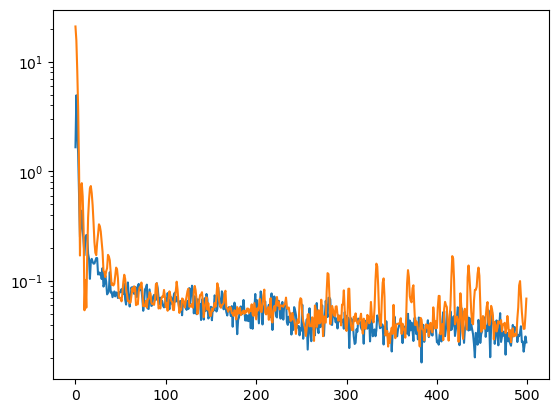

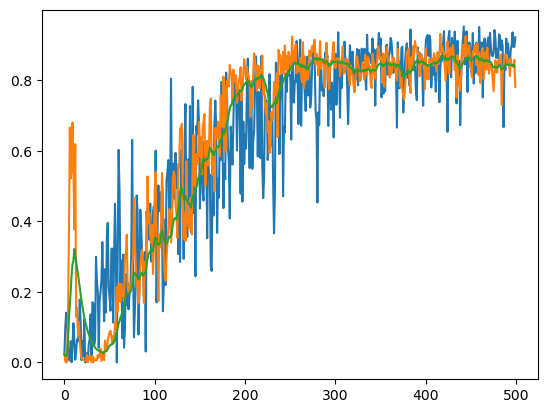

In [5]:
plt.semilogy(train_losses)
plt.plot(val_losses)
#plt.ylim(0,0.01)
plt.show()

plt.plot(train_r2s)
plt.plot(val_r2s)
plt.plot(val_r2_emas)
plt.show()